## Annotate cell states via coarse graining denserank marker gene scores for each cell by leiden cluster - Figure 1C (optionally include stretch signature cell state)

In [1]:
%matplotlib inline

In [2]:
import os
import helper_functions_GSE164638 as hf
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

<div class="alert alert-info">
    
# Navigating this notebook
*** *** 
**Input/Output & Parameters**
0. [Directories and Defining parameters](#step0)
1. [Plot formatting](#plot_format)
1. [Load data](#load_data)
    <br>
    <br>   
    
**Annotating cell states**
2. [Classify cells based on marker gene scores](#annotation)
3. [Coarse grained states - Figure 6A](#6A)
    <br>
    <br>
    
**Quick visualization and differential gene expression analysis**    
4. [Plot each treatment cluster - Figure S3A](#S3A) 
5. [Calculate and examine differentially expressed genes based on coarse-grained state](#dge)
    <br>
    <br>
    
**Save files**
5. [Save data files](#save_all)
6. [Export to SPRING](#spring)
    
</div>  

*** ***

<a id='step0'></a>

## Directories for input and output data

In [3]:
# for AnnData objects from Scanpy:
# These AnnData objects contain output from the filtering and QC notebook
# Containing unnormalized counts matrices with low-count barcodes removed
h5ad_dir = '_h5ad_files'
os.makedirs(h5ad_dir, exist_ok=True)

spring_main='_spring'
os.makedirs(spring_main, exist_ok=True)

<a id='plot_format'></a>

## Plot formatting

In [4]:
# Set up parameter settings for plots

# matplotlib params:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rc('font', size=12)
plt.rcParams['pdf.fonttype'] = 42

# scanpy settings:
sc.settings.verbosity = 2  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=150)  # low dpi (dots per inch) yields small inline figure

In [5]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14, 
                         figsize=None, color_map=None, 
                         format='eps', facecolor='white', transparent=False, ipython_format='png2x')

<a id='load_data'></a>

## Load experiment data

In [6]:
adata = sc.read(f'{h5ad_dir}/adata_pp_merged_batch_correct_sand_dome.h5ad')

#### Double check that the raw data is actually untransformed counts matrix

In [7]:
(adata.raw.X.sum(axis=1) > 1e4).sum()

1003

In [8]:
(adata.X.sum(axis=1) > 1e4).sum() # log normalized and z-scored - do NOT use for calculations!!!

0

*** ***

<a id='annotation'></a>

## Classify states based on marker gene scores

### Load marker genes

In [9]:
#read in differentially expressedmg_dict genes
df_exp_gene_xl = pd.read_excel('marker_genes_used_for_annotation_no_stretch_signature.xlsx')

# optionally, to include stretch signature annotation replace with: 
#df_exp_gene_xl = pd.read_excel('marker_genes_used_for_annotation.xlsx')

In [10]:
del df_exp_gene_xl['Unnamed: 0'] # added when reading in excel with pandas

In [11]:
# create marker gene dictionary
mg_dict = {}
for state, mg_list in df_exp_gene_xl.items():
    mg_list_cleaned = [x for x in mg_list if str(x) != 'nan' and x in list(adata.var_names)]
    mg_dict[state] = mg_list_cleaned

### Classify states by gene scores

In [12]:
for state, mg_list in mg_dict.items():
    hf.calc_score_denserank(adata, f'state_marker_{state}', mg_dict[f'{state}'])

hf.classify_gene_score(adata, 'gene_score_state_marker_')

### Take a look at the single cell landscape in UMAP space

... storing 'classify_gene_score_state_marker_' as categorical


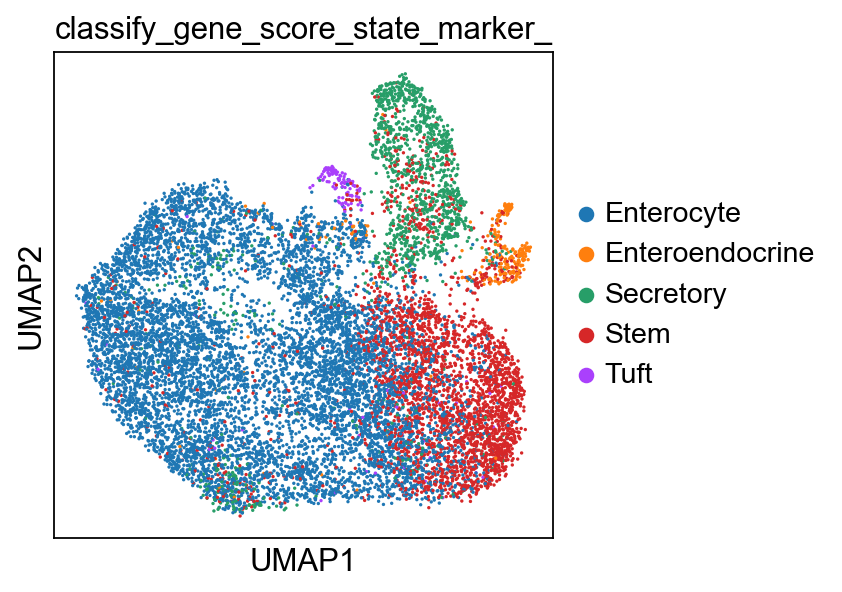

In [13]:
sc.pl.umap(adata, color='classify_gene_score_state_marker_')

### Coarse grain annotations based on cluster consensus

In [14]:
# annotate with more concise name
adata.obs['state'] = adata.obs['classify_gene_score_state_marker_']

In [15]:
def coarse_grain_classification(adata, state_group, cluster_group, threshold):
    #this function will coarse grain annotations based on the consensus in the cluster
    #the criteria is that any annotation with less than a fraction (threshold) 
    #of cells in the cluster is replaced with the majority annotation
    #Ex. suggest to use threshold = 0.1
    
    d_dict = {}
    
    n_cat = len(adata.obs[f'{cluster_group}'].cat.categories)
    
    # calculate the fraction of cells in each cluster in each state:
    for cluster in adata.obs[f'{cluster_group}'].cat.categories:
        cl_frac_state = {}
        num_cluster = (adata.obs[f'{cluster_group}'] == f'{cluster}').sum()
        for cat_ in adata.obs[f'{state_group}'].cat.categories:
            num_state = len(adata.obs[adata.obs[f'{cluster_group}'] == f'{cluster}'].loc[adata.obs[f'{state_group}'] == f'{cat_}'])
            cl_frac_state[cat_] = num_state/num_cluster # fraction of cells per state in each cluster
        d_dict[f'{cluster}'] = cl_frac_state
    
    # identify the max annotation per cluster, and annotations less than threshold
    cluster_annot = {}
    cluster_thresh = {}
    for cluster, dict_ in d_dict.items():
        cluster_df = pd.DataFrame.from_dict(dict_, orient='index')
        cluster_annot[cluster] = cluster_df.idxmax()
        cluster_thresh[cluster] = list(cluster_df[cluster_df[0] <= threshold].index)
    
            
    cluster_annot_df = pd.DataFrame.from_dict(cluster_annot)
    cluster_annot_df = cluster_annot_df.transpose()
    cluster_annot_df = cluster_annot_df.rename(columns={0: f'{state_group}'})
    
    #initialize so that the new column has old ids 
    adata.obs['state_coarse_grain'] = adata.obs['state'] #initialize so that the new column has old ids 
    
    for cluster in adata.obs[f'{cluster_group}'].unique():
        for state in cluster_thresh[cluster]:
            adata.obs[f'{state_group}_coarse_grain'].loc[(adata.obs[f'{state_group}'] == state) & \
                                                         (adata.obs[f'{cluster_group}'] == cluster)] \
            = cluster_annot_df[f'{state_group}'][cluster]

In [16]:
coarse_grain_classification(adata, 'state', 'leiden', 0.3)

### Plot the coarse grained states

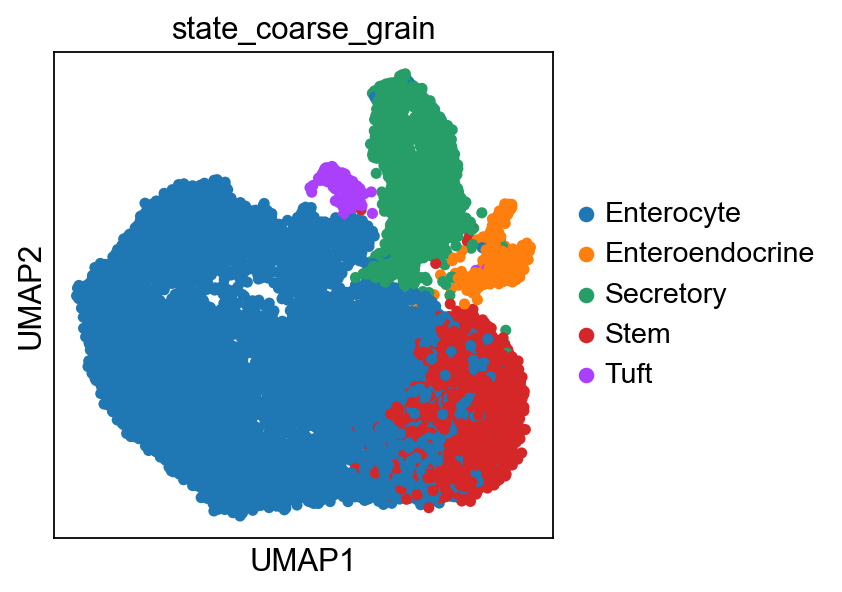

In [17]:
sc.pl.umap(adata, s=100, color='state_coarse_grain', save='_state_coarse_grain_sand_dome')

*** ***

<a id='dge'></a>

## Calculate and examine differentially expressed genes based on coarse-grained state

In [18]:
sc.tl.rank_genes_groups(adata, groupby='state_coarse_grain', method='wilcoxon')

ranking genes
    finished (0:00:23)


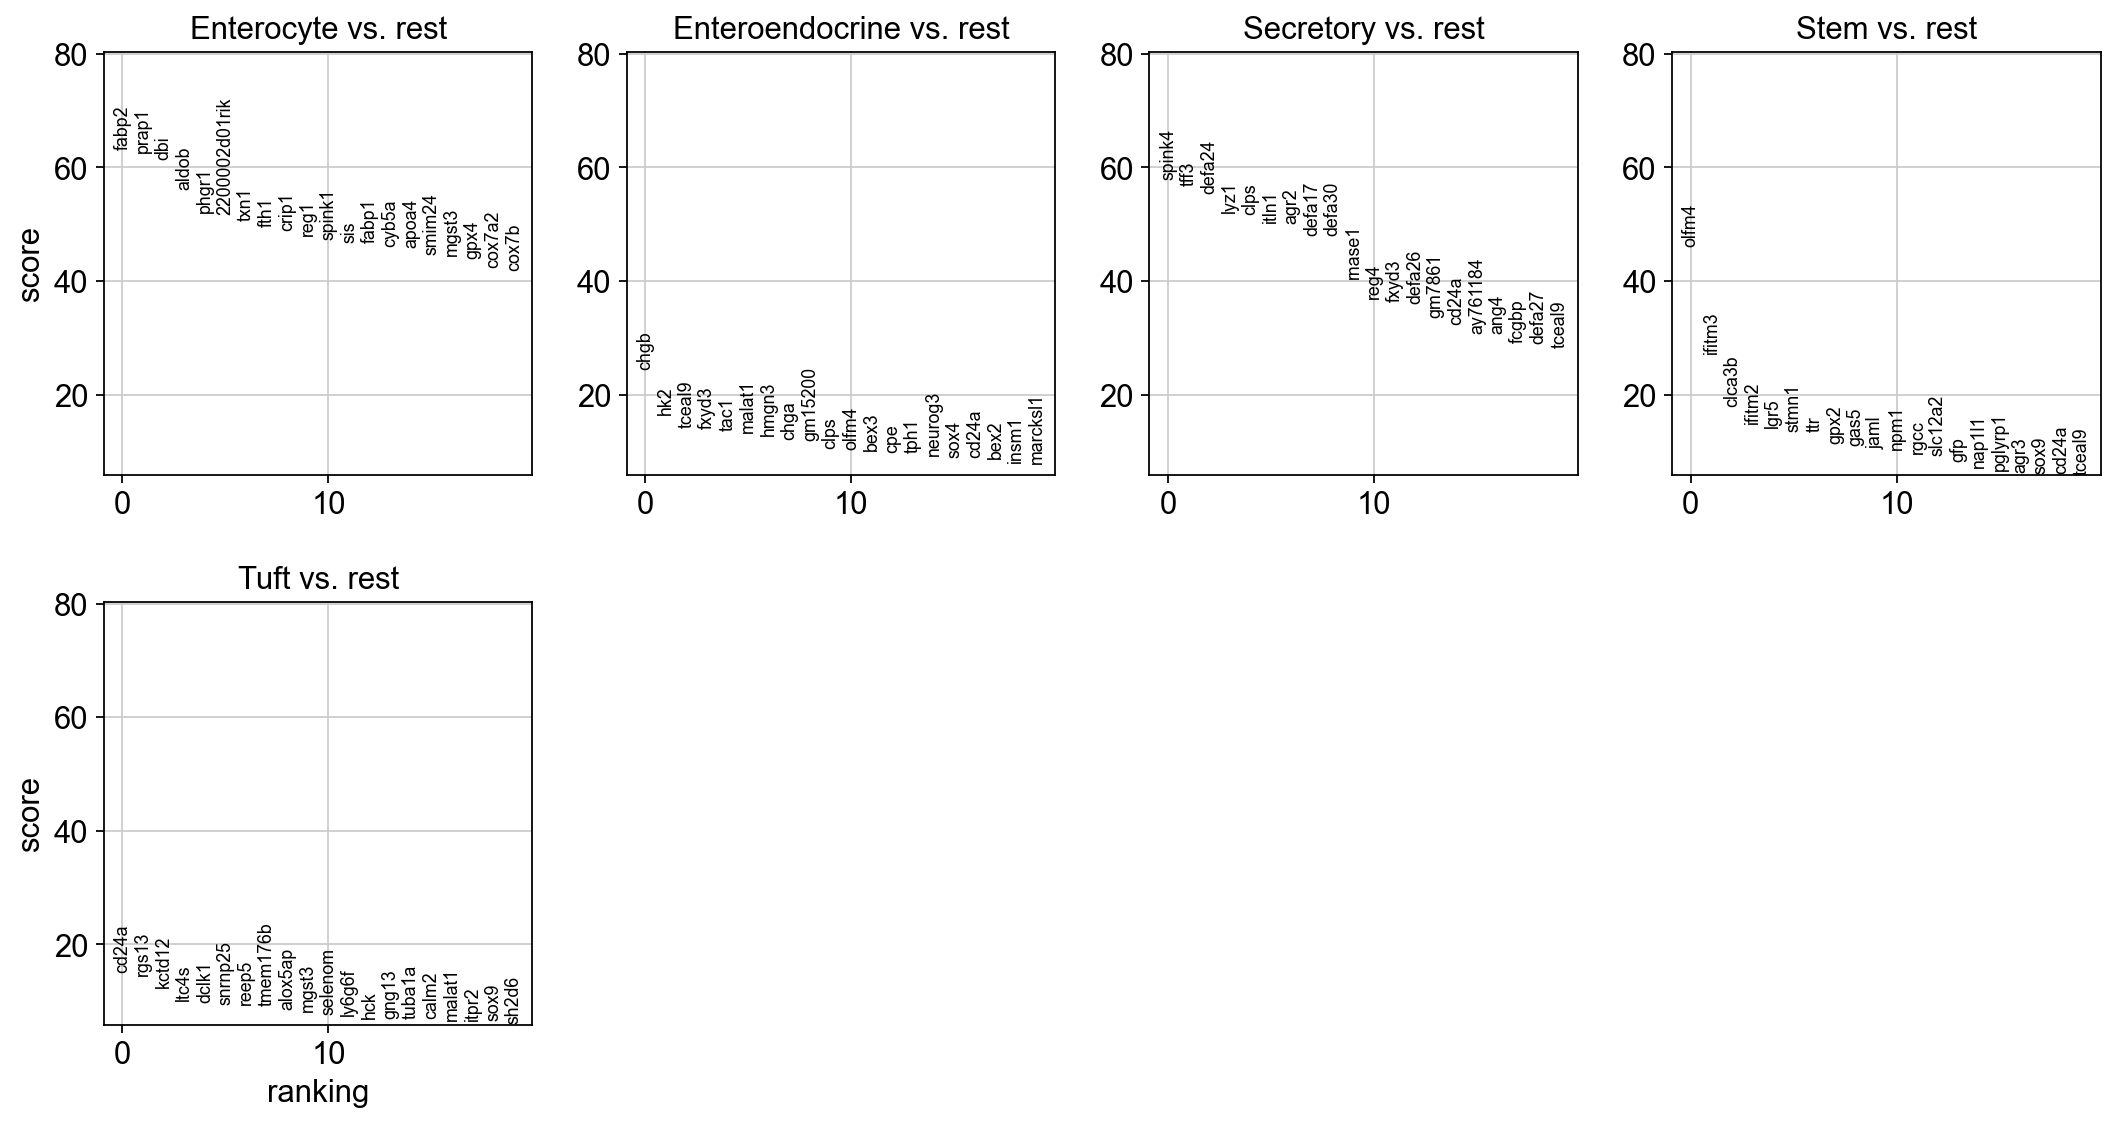

In [19]:
sc.pl.rank_genes_groups(adata, groupby='state_coarse_grain', key='rank_genes_groups')

*** ***

<a id='spring'></a>

## Save files

### Save h5ad file

In [20]:
sc.write(f'{h5ad_dir}/adata_annotated_sand_dome.h5ad', adata)

In [21]:
adata = sc.read(f'{h5ad_dir}/adata_annotated_sand_dome.h5ad')

### Save meta-data

In [22]:
umap_coords = pd.DataFrame(adata.obsm['X_umap']).rename(columns={0:'UMAP_X', 1:'UMAP_Y'})

In [23]:
adata.obs['UMAP_X'] = list(umap_coords['UMAP_X'])

In [24]:
adata.obs['UMAP_Y'] = list(umap_coords['UMAP_Y'])

In [25]:
adata.obs.to_excel('sandwich_dome_metadata.xlsx')

## Export to SPRING

<div class="alert alert-info">
    
***As described in: Caleb Weinreb, Samuel Wolock, Allon M Klein, SPRING: a kinetic interface for visualizing high dimensional single-cell expression data, Bioinformatics, Volume 34, Issue 7, 01 April 2018, Pages 1246–1248, https://doi.org/10.1093/bioinformatics/btx792***
    
</div>

In [26]:
categorical_vars = ['state', 'condition', 'batch', 'leiden', 'phase', 'included after filter', 'Library Name']
for k in categorical_vars:
    adata.obs[k] = pd.Categorical(adata.obs[k])

In [27]:
del adata.raw

In [28]:
#you will need to drag from this folder to the Spring Dev folder in order to actually run it!!
spring_plot_dir = spring_main+'/murine_intestinal_organoid_sandwich_dome_culture_merged_no_stretch_signature'
sc.external.exporting.spring_project(
    adata, 
    project_dir=spring_plot_dir, 
    subplot_name='all_cells',
    embedding_method='umap',
    cell_groupings=categorical_vars,
    custom_color_tracks=['gene_score_z_state_marker_Enteroendocrine',
       'gene_score_z_state_marker_Stretch Signature',
        'gene_score_z_state_marker_Secretory',
        'gene_score_z_state_marker_Stem',
        'gene_score_z_state_marker_Tuft',
       'gene_score_z_state_marker_Enterocyte', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'percent_mito', 'mito_frac',
       'percent_ribo', 'n_genes', 'S_score', 'G2M_score'],
    overwrite=True
)
#url (after navigating to SPRING_dev_new): 
#new: http://localhost:8000/springViewer_1_6_dev.html?data/sandwich_dome_culture_merged_no_stretch_signature/all_cells

Writing subplot to _spring/murine_intestinal_organoid_sandwich_dome_culture_merged_no_stretch_signature/all_cells


<a id='save_all'></a>